In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from collections import defaultdict
import time

#### Importing the dataset

rating_dataset is the Surprise dataset that can be used when analyzing the full dataset.
<br>
rating_matrix is the numpy array that has columns: userId, movieId, rating, timestamp

In [2]:
from surprise import Reader, Dataset

In [3]:
# Read data set using pandas and surprise. Data is stored in rating_dataset

df=pd.read_csv('ml-latest-small/ratings.csv')
# reader = Reader(rating_scale=(1,5))
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)

rating_dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
rating_matrix = df.values

# Get the all ratings for each movie. Key is movie ID, value of an array of ratings.
ratings_by_movie_id_full = {}
for row in rating_dataset.raw_ratings:
    if row[1] not in ratings_by_movie_id_full:
        ratings_by_movie_id_full[row[1]] = []
    ratings_by_movie_id_full[row[1]].append(row[2])

# Count number of users and movies.
num_users = np.size(np.unique(rating_matrix[:,0]))
num_movies = np.size(np.unique(rating_matrix[:,1]))

##### Build R Matrix

In [4]:
R = np.zeros([num_users, num_movies])

ratings = np.genfromtxt('ml-latest-small/ratings.csv', delimiter=',')
ratings = np.delete(ratings, (0), axis=0) # Remove column title row
ratings = np.delete(ratings, (3), axis=1) # Remove time stamp column

# Create a dictionary where the key is the movie id and the value is the location in data

movie_ids = {}
counter = 0
for rating in ratings:
    if rating[1] not in movie_ids.keys():
        movie_ids[rating[1]] = counter
        counter += 1
        
# Put ratings into a matrix of size num_users x num_movies. 
# To get the rating of a user for a specific movie, do data[userId - 1, movie_ids[movieId]]

for rating in ratings:
    user = int(rating[0]) - 1
    movie = int(movie_ids[rating[1]])
    R[user, movie] = rating[2]
    
print(R)

[[4.  4.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  0.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  5.  ... 3.  3.5 3.5]]


#### Question 1

In [5]:
# Calculate sparsity, defined as: (total number of available ratings) / (total number of possible ratings)

num_available_ratings = np.size(rating_matrix[:,0])
num_possible_ratings = num_users*num_movies

sparsity = num_available_ratings / num_possible_ratings

print('Sparsity = {}'.format(sparsity))

Sparsity = 0.016999683055613623


#### Question 2

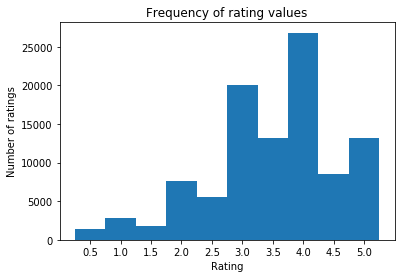

In [6]:
# Plot a histogram showing the frequency of rating values

ratings = rating_matrix[:,2]
plt.figure()
# plt.hist(ratings, 10)
plt.hist(ratings, np.arange(0.5, 6, 0.5))
plt.title('Frequency of rating values')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.xticks(np.arange(0.75, 5.75, 0.5), np.arange(0.5, 5.5, 0.5))
plt.show()

#### Question 3

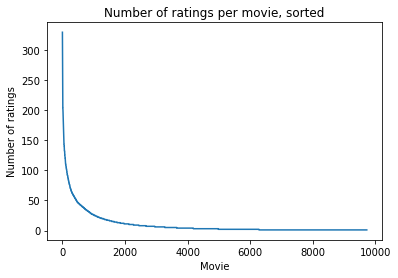

In [7]:
# Distribution of number of ratings received per movie.

movies = rating_matrix[:,1]
movie_id, counts = np.unique(movies, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per movie, sorted')
plt.xlabel('Movie')
plt.ylabel('Number of ratings')
plt.show()

#### Question 4

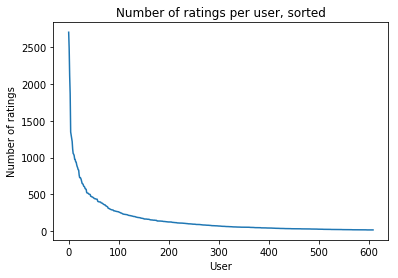

In [8]:
# Distribution of number of ratings given per user

users = rating_matrix[:,0]
user_id, counts = np.unique(users, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per user, sorted')
plt.xlabel('User')
plt.ylabel('Number of ratings')
plt.show()

#### Question 6

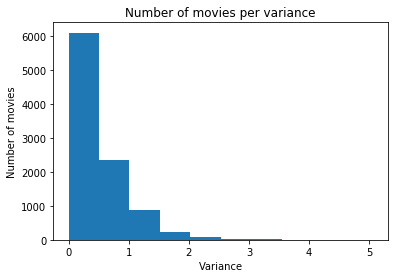

In [9]:
# Histogram of variance in ratings per movie

var_by_movie_id = {}
for key in ratings_by_movie_id.keys():
    var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    
variances = list(var_by_movie_id.values())

plt.figure()
plt.hist(variances)
plt.title('Number of movies per variance')
plt.xlabel('Variance')
plt.ylabel('Number of movies')
plt.show()

#### Trimming the dataset

Creating functions to trim the test set for later use.

In [10]:
def get_popular(testset):
    testset_pop = [k for k in testset if len(ratings_by_movie_id_full[k[1]]) > 2]
    return testset_pop

In [11]:
def get_unpopular(testset):
    testset_unpop = [k for k in testset if len(ratings_by_movie_id_full[k[1]]) <= 2]
    return testset_unpop

In [12]:
def get_highvar(testset):
    var_by_movie_id_full = {}
    for key in ratings_by_movie_id_full.keys():
        var_by_movie_id_full[key] = np.var(ratings_by_movie_id_full[key])
    testset_highvar = [k for k in testset if len(ratings_by_movie_id_full[k[1]]) >= 5 and var_by_movie_id_full[k[1]] >= 2]
    return testset_highvar

## Question 10

In [13]:
from surprise import KNNBasic, KNNWithMeans
from surprise import evaluate
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [14]:
ks = np.arange(2, 101, 2)

In [15]:
# Analyze full dataset

rmse_scores = []
mae_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    result = cross_validate(knn, rating_dataset, measures=['rmse', 'mae'], cv=10)
    
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    
    print('k = {}'.format(k))
    print('RMSE = {}'.format(rmse))
    print('MAE = {}'.format(mae))
    print(' ')
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

k = 2
RMSE = 1.0187827013322452
MAE = 0.7866407977490923
 
k = 4
RMSE = 0.9455328054750858
MAE = 0.7260639965825444
 
k = 6
RMSE = 0.9203151167501801
MAE = 0.7053801019289716
 
k = 8
RMSE = 0.9091969864872793
MAE = 0.6952700600507803
 
k = 10
RMSE = 0.9021607744781033
MAE = 0.6885918665636356
 
k = 12
RMSE = 0.8988256911740653
MAE = 0.6861939470112409
 
k = 14
RMSE = 0.8952631419010626
MAE = 0.6830007342124835
 
k = 16
RMSE = 0.893949208155534
MAE = 0.6813357999766246
 
k = 18
RMSE = 0.8928098483942835
MAE = 0.68075079333793
 
k = 20
RMSE = 0.8914761600836995
MAE = 0.6796359123683752
 
k = 22
RMSE = 0.8905352120758453
MAE = 0.6785802064993165
 
k = 24
RMSE = 0.8912695144443671
MAE = 0.6788646441479929
 
k = 26
RMSE = 0.891055402437517
MAE = 0.6788144275606153
 
k = 28
RMSE = 0.8901854634140438
MAE = 0.6783194934043915
 
k = 30
RMSE = 0.8899872587551112
MAE = 0.6776375275325595
 
k = 32
RMSE = 0.8898729101927177
MAE = 0.6774511175607719
 
k = 34
RMSE = 0.8904663708944055
MAE = 0.6779665

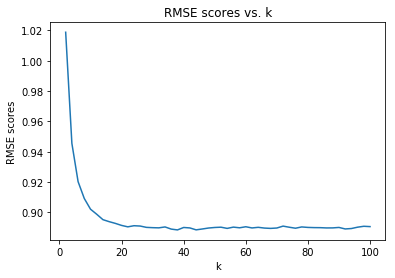

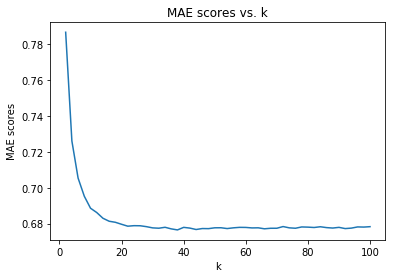

In [16]:
plt.figure()
plt.plot(ks, rmse_scores)
plt.title('RMSE scores vs. k')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

plt.figure()
plt.plot(ks, mae_scores)
plt.title('MAE scores vs. k')
plt.xlabel('k')
plt.ylabel('MAE scores')
plt.show()

## Question 11

In [17]:
# Finding the minimum k -- I think this has to be done by observing the graph and not through code.
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_scores)]))
print('Best k for MAE: {}'.format(ks[np.argmin(mae_scores)]))

Best k for RMSE: 38
Best k for MAE: 38


## Question 12

In [18]:
# Analyze popular dataset.

rmse_popular_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        knn.fit(trainset)
        predictions = knn.test(pop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_popular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print('Average RMSE = {}'.format(avg_rmse))
    print(' ')

k = 2
Average RMSE = 1.020288720680802
 
k = 4
Average RMSE = 0.9295909506076665
 
k = 6
Average RMSE = 0.8988769602869524
 
k = 8
Average RMSE = 0.8850375536862355
 
k = 10
Average RMSE = 0.8744337355348748
 
k = 12
Average RMSE = 0.8699978482049184
 
k = 14
Average RMSE = 0.8654295120989899
 
k = 16
Average RMSE = 0.8633758560727379
 
k = 18
Average RMSE = 0.8624809570913549
 
k = 20
Average RMSE = 0.8618559389521551
 
k = 22
Average RMSE = 0.8577621850405475
 
k = 24
Average RMSE = 0.8604583461593178
 
k = 26
Average RMSE = 0.8588807070394155
 
k = 28
Average RMSE = 0.8577314438936143
 
k = 30
Average RMSE = 0.8569739767895939
 
k = 32
Average RMSE = 0.8557714026678683
 
k = 34
Average RMSE = 0.8564917463694497
 
k = 36
Average RMSE = 0.8560773280251315
 
k = 38
Average RMSE = 0.8571524577769545
 
k = 40
Average RMSE = 0.8571519744237485
 
k = 42
Average RMSE = 0.8547224510279372
 
k = 44
Average RMSE = 0.856289251111604
 
k = 46
Average RMSE = 0.8535024940149706
 
k = 48
Average RM

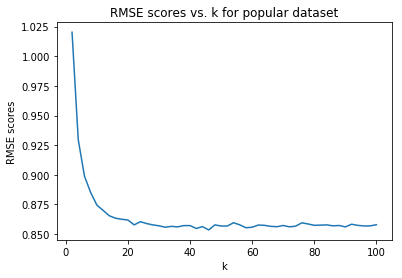

In [19]:
plt.figure()
plt.plot(ks, rmse_popular_scores)
plt.title('RMSE scores vs. k for popular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [20]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_popular_scores)]))

Best k for RMSE: 46


## Question 13

In [21]:
# Unpopular Movie Trimmed Test Set

# Analyze unpopular dataset

rmse_unpopular_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        unpop_testset = get_unpopular(testset)
        knn.fit(trainset)
        predictions = knn.test(unpop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_unpopular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print("Average RMSE = {}".format(avg_rmse))
    print(' ')

k = 2
Average RMSE = 1.0199151659833878
 
k = 4
Average RMSE = 0.9784508031655772
 
k = 6
Average RMSE = 0.9658455647540218
 
k = 8
Average RMSE = 0.9642547043339984
 
k = 10
Average RMSE = 0.9575557785405078
 
k = 12
Average RMSE = 0.9553552280305704
 
k = 14
Average RMSE = 0.9612993292474507
 
k = 16
Average RMSE = 0.9583802709952838
 
k = 18
Average RMSE = 0.9565391743775956
 
k = 20
Average RMSE = 0.9567906405371442
 
k = 22
Average RMSE = 0.9592134556054184
 
k = 24
Average RMSE = 0.9603980584069463
 
k = 26
Average RMSE = 0.9611561489290408
 
k = 28
Average RMSE = 0.959776746129325
 
k = 30
Average RMSE = 0.9581598539044365
 
k = 32
Average RMSE = 0.9611177718194543
 
k = 34
Average RMSE = 0.9528931737284643
 
k = 36
Average RMSE = 0.9551083327828623
 
k = 38
Average RMSE = 0.9608493055503138
 
k = 40
Average RMSE = 0.9539062242809615
 
k = 42
Average RMSE = 0.9568400358760327
 
k = 44
Average RMSE = 0.9581647463559783
 
k = 46
Average RMSE = 0.9581890317033265
 
k = 48
Average R

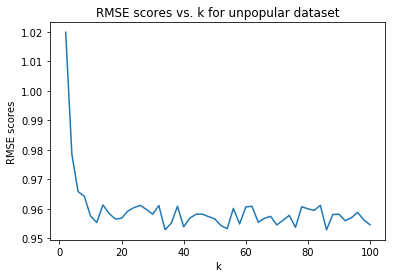

In [22]:
plt.figure()
plt.plot(ks, rmse_unpopular_scores)
plt.title('RMSE scores vs. k for unpopular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [23]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_unpopular_scores)]))

Best k for RMSE: 86


## Question 14

In [24]:
# Analyze high variance dataset with KNN

rmse_highvar_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        highvar_testset = get_highvar(testset)
        knn.fit(trainset)
        predictions = knn.test(highvar_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_highvar_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print('Average RMSE = {}'.format(avg_rmse))
    print(' ')

k = 2
Average RMSE = 1.491027160121544
 
k = 4
Average RMSE = 1.4509452255268365
 
k = 6
Average RMSE = 1.4496327885655202
 
k = 8
Average RMSE = 1.393180422260285
 
k = 10
Average RMSE = 1.4025386968483569
 
k = 12
Average RMSE = 1.38591145261378
 
k = 14
Average RMSE = 1.3933347308225457
 
k = 16
Average RMSE = 1.3931619839696494
 
k = 18
Average RMSE = 1.4162996657349392
 
k = 20
Average RMSE = 1.3732171369715729
 
k = 22
Average RMSE = 1.4235635049433428
 
k = 24
Average RMSE = 1.464655604155661
 
k = 26
Average RMSE = 1.4107069298391175
 
k = 28
Average RMSE = 1.4123344940289733
 
k = 30
Average RMSE = 1.3851496666720595
 
k = 32
Average RMSE = 1.4063107281405598
 
k = 34
Average RMSE = 1.4042681336759049
 
k = 36
Average RMSE = 1.427199917820904
 
k = 38
Average RMSE = 1.4225742400851302
 
k = 40
Average RMSE = 1.4109145772817084
 
k = 42
Average RMSE = 1.413072842774319
 
k = 44
Average RMSE = 1.4156241741204767
 
k = 46
Average RMSE = 1.4048698021043946
 
k = 48
Average RMSE = 

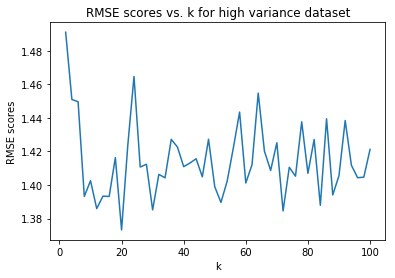

In [25]:
plt.figure()
plt.plot(ks, rmse_highvar_scores)
plt.title('RMSE scores vs. k for high variance dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [26]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_highvar_scores)]))

Best k for RMSE: 20


## Question 15

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split

In [43]:
thresholds = [2.5, 3, 3.5, 4]
best_k_knn = 21

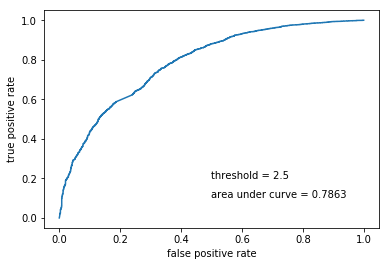

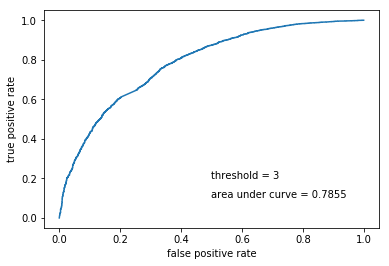

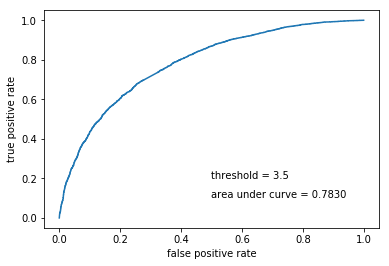

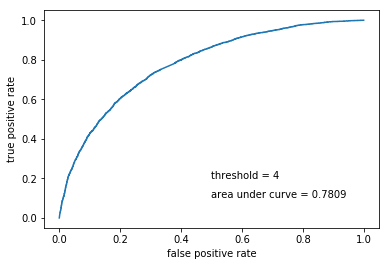

In [44]:
knn = KNNWithMeans(k=best_k_knn, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
knn.fit(trainset)
predictions = knn.test(testset)
for t in thresholds:
    true_bin = [1 if pred.r_ui >= t else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]
    
    plt.figure()
    fpr, tpr, thr = roc_curve(true_bin, scores)
    plt.plot(fpr, tpr)
    plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(true_bin, scores))
    plt.text(0.5, 0.2, 'threshold = {}'.format(t))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

### NMF

In [36]:
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

#### Question 17, 18

In [37]:
ks = np.arange(2, 51, 2)

In [39]:
# Analyze full dataset

rmse_scores = []
mae_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    result = cross_validate(nmf, rating_dataset, measures=['rmse', 'mae'], cv=10)
    
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    
    print('k = {}'.format(k))
    print(rmse)
    print(mae)
    print(' ')
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

k = 2
1.146128962595108
0.9633459240639326
 
k = 4
1.038383813636784
0.8486986736662928
 
k = 6
0.9823324917773434
0.7865541382157435
 
k = 8
0.9496199333586404
0.7481533724714058
 
k = 10
0.9314443106560676
0.7259302945247932
 
k = 12
0.9210761642980326
0.7115466011035502
 
k = 14
0.9144861561435963
0.7021084713569101
 
k = 16
0.9148780522677908
0.6992663499500555
 
k = 18
0.9130071174361243
0.6954223879718207
 
k = 20
0.9161478467533197
0.6946295498184482
 
k = 22
0.9176507156865028
0.6944643805654339
 
k = 24
0.9177233749984796
0.6939372512642524
 
k = 26
0.9229385713258633
0.6968238017163783
 
k = 28
0.9276856957846267
0.6994940232626338
 
k = 30
0.9295714060595397
0.7008020368403112
 
k = 32
0.9342584535349421
0.7045218758695391
 
k = 34
0.9371080777287288
0.7059225995499626
 
k = 36
0.9433335622709981
0.7097746184428132
 
k = 38
0.9474380742801284
0.7129769018248127
 
k = 40
0.9504879560115465
0.7158052961427133
 
k = 42
0.9529910031439559
0.7181296564407144
 
k = 44
0.9571818297

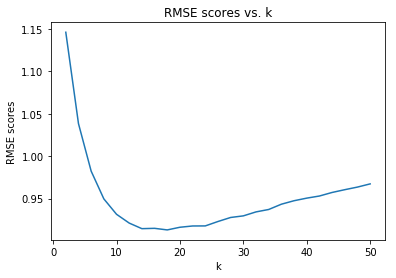

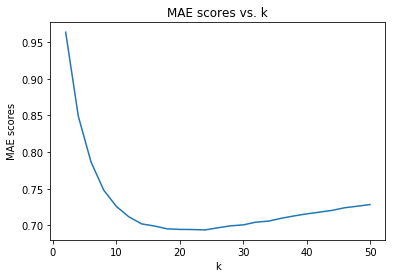

In [40]:
plt.figure()
plt.plot(ks, rmse_scores)
plt.title('RMSE scores vs. k')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

plt.figure()
plt.plot(ks, mae_scores)
plt.title('MAE scores vs. k')
plt.xlabel('k')
plt.ylabel('MAE scores')
plt.show()

In [41]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_scores)]))
print('Best k for MAE: {}'.format(ks[np.argmin(mae_scores)]))

Best k for RMSE: 18
Best k for MAE: 24


#### Question 19

In [42]:
# Analyze popular dataset.

rmse_popular_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        nmf.fit(trainset)
        predictions = nmf.test(pop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_popular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.137866230223612
 
k = 4
1.015006432671863
 
k = 6
0.9464596979136299
 
k = 8
0.9080105592468012
 
k = 10
0.8891814730695774
 
k = 12
0.879751153344684
 
k = 14
0.8727754751853134
 
k = 16
0.8708652305299026
 
k = 18
0.8745410493005987
 
k = 20
0.8767621543186458
 
k = 22
0.8784568738053051
 
k = 24
0.884458015742044
 
k = 26
0.8874450933556082
 
k = 28
0.8901248180080803
 
k = 30
0.899450705003391
 
k = 32
0.9025220089825566
 
k = 34
0.9073762853140448
 
k = 36
0.914915158629183
 
k = 38
0.9173164281390618
 
k = 40
0.9211253653464541
 
k = 42
0.9297956201880743
 
k = 44
0.9331796165260975
 
k = 46
0.9350164047942051
 
k = 48
0.940632426978399
 
k = 50
0.9468359003726363
 


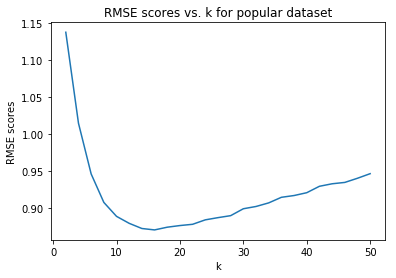

In [43]:
plt.figure()
plt.plot(ks, rmse_popular_scores)
plt.title('RMSE scores vs. k for popular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [44]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_popular_scores)]))

Best k for RMSE: 16


#### Question 20

In [45]:
# Analyze unpopular dataset

rmse_unpopular_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        unpop_testset = get_unpopular(testset)
        nmf.fit(trainset)
        predictions = nmf.test(unpop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_unpopular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.1638167476675376
 
k = 4
1.0912186431256956
 
k = 6
1.0500479054837009
 
k = 8
1.0297314886793958
 
k = 10
1.0175771274289864
 
k = 12
1.0053615971571124
 
k = 14
0.9981624983528752
 
k = 16
0.9992551793344671
 
k = 18
0.9957316693071325
 
k = 20
0.9966558281624815
 
k = 22
0.9906676004296052
 
k = 24
0.9958524584322817
 
k = 26
0.9957688876178536
 
k = 28
0.9955408868295657
 
k = 30
0.995533504394856
 
k = 32
1.0012194637437506
 
k = 34
1.003105118881769
 
k = 36
1.0077264842824123
 
k = 38
1.0028041234679037
 
k = 40
1.0045793302584425
 
k = 42
1.00463718632026
 
k = 44
1.0087941252996182
 
k = 46
1.0127566877584928
 
k = 48
1.0125418453216892
 
k = 50
1.0166510085897098
 


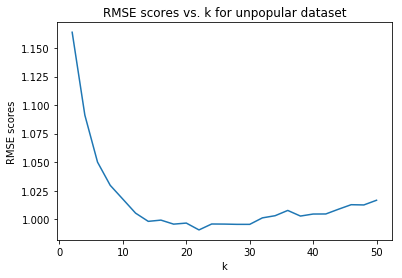

In [46]:
plt.figure()
plt.plot(ks, rmse_unpopular_scores)
plt.title('RMSE scores vs. k for unpopular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [47]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_unpopular_scores)]))

Best k for RMSE: 22


#### Question 21

In [49]:
# Analyze high variance dataset

rmse_highvar_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        highvar_testset = get_highvar(testset)
        nmf.fit(trainset)
        predictions = nmf.test(highvar_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_highvar_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.462199615456143
 
k = 4
1.4275058714139164
 
k = 6
1.3819990911907392
 
k = 8
1.3948323264929272
 
k = 10
1.3941022755691912
 
k = 12
1.4000956803844506
 
k = 14
1.3986491221195103
 
k = 16
1.4250211388834324
 
k = 18
1.4132684902594232
 
k = 20
1.4336694976119924
 
k = 22
1.467830136477057
 
k = 24
1.4487020337905268
 
k = 26
1.4818124450938417
 
k = 28
1.4344190964434345
 
k = 30
1.454007765919362
 
k = 32
1.4504688894017068
 
k = 34
1.4624392640224577
 
k = 36
1.5204698208432623
 
k = 38
1.465358340944009
 
k = 40
1.5048406288522385
 
k = 42
1.494536088390023
 
k = 44
1.5482132729750924
 
k = 46
1.5379723423181004
 
k = 48
1.564704517733078
 
k = 50
1.5333582843369862
 


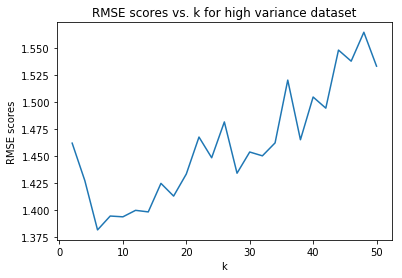

In [50]:
plt.figure()
plt.plot(ks, rmse_highvar_scores)
plt.title('RMSE scores vs. k for high variance dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [51]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_highvar_scores)]))

Best k for RMSE: 6


#### Question 22

In [52]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise import NMF
from surprise.model_selection import train_test_split

In [53]:
thresholds = [2.5, 3, 3.5, 4]
best_k = 16

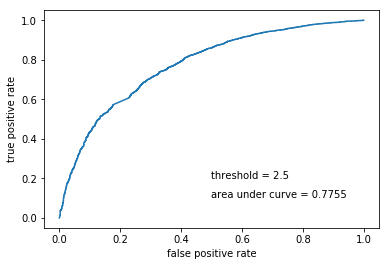

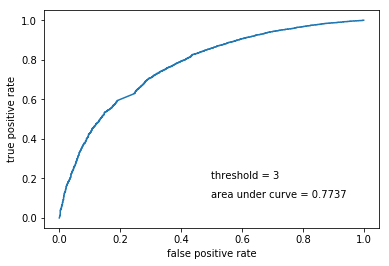

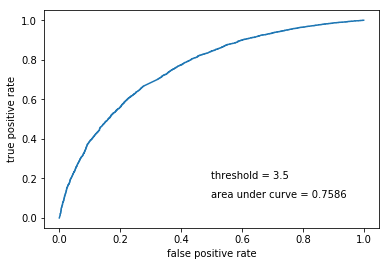

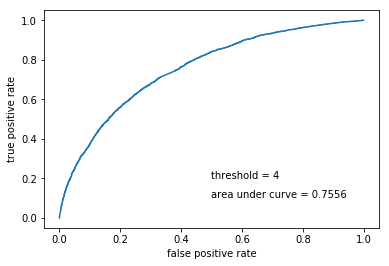

In [54]:
nmf = NMF(n_factors=best_k)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
nmf.fit(trainset)
predictions = nmf.test(testset)
for t in thresholds:
    true_bin = [1 if pred.r_ui >= t else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]
    
    plt.figure()
    fpr, tpr, thr = roc_curve(true_bin, scores)
    plt.plot(fpr, tpr)
    plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(true_bin, scores))
    plt.text(0.5, 0.2, 'threshold = {}'.format(t))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

#### Question 23

In [55]:
from surprise import NMF

In [56]:
df=pd.read_csv('ml-latest-small/ratings.csv')
df_movies=pd.read_csv('ml-latest-small/movies.csv')
nmf = NMF(n_factors=20, random_state=0)
nmf.fit(rating_dataset.build_full_trainset())
V = nmf.qi

In [57]:
for f in range(20):
    temp = [[V[:,f][k], k] for k in range(np.size(V[:,0]))]
    temp.sort(key=lambda x: x[0])
    temp.reverse()
    print('Feature {} top 10 genres'.format(f+1))
    for i in range(10):
        print(df_movies['genres'][temp[i][1]])
    print(' ')

Feature 1 top 10 genres
Comedy|Drama|Romance
Horror|Sci-Fi
Crime|Drama|Musical
Comedy|Drama|Romance
Drama|Romance
Comedy
Drama|Mystery|Sci-Fi|Thriller
Drama
Drama
Drama|Thriller|War
 
Feature 2 top 10 genres
Drama|Western
Drama|Musical
Film-Noir|Thriller
Comedy
Comedy|Romance
Comedy
Action|Comedy
Action|Crime|Thriller
Horror|Sci-Fi|Thriller
Children|Comedy
 
Feature 3 top 10 genres
Comedy|Drama|Romance
Horror|Thriller
Drama
Drama|Romance
Adventure|Children
Drama|Romance
Drama
Crime|Drama|Film-Noir|Thriller
Drama
Adventure|Children|Comedy|Mystery
 
Feature 4 top 10 genres
Drama
Children|Drama
Thriller
Action|Adventure|Fantasy|Sci-Fi
Comedy|Romance
Comedy
Action|Adventure|Comedy
Documentary
Comedy|Crime
Comedy|Romance
 
Feature 5 top 10 genres
Drama
Horror|Thriller
Drama
Action|Comedy|Sci-Fi
Comedy
Drama
Drama
Comedy
Comedy|Drama|Thriller
Crime|Drama
 
Feature 6 top 10 genres
Documentary
Comedy
Comedy|Drama|Romance
Horror
Adventure|Animation|Children|Comedy
Drama
Comedy|Drama
Crime|Fanta

### MF with Bias

#### Question 24

Design a MF with bias collaborative filter on full data set.

In [31]:
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [59]:
ks = np.arange(2, 51, 2)

# MF with Bias, Full data set

rmse_scores = []
mae_scores = []

for k in ks:
    svd = SVD(n_factors=k)
    result = cross_validate(svd, rating_dataset, cv = 10)
    
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    
    print('k = {}'.format(k))
    print(rmse)
    print(mae)
    print(' ')
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

k = 2
0.8670574662586743
0.6655094207803763
 
k = 4
0.8664564795842713
0.6658729354877889
 
k = 6
0.8665738691849052
0.6655752271967791
 
k = 8
0.8655244939306315
0.6649137919222816
 
k = 10
0.866101044190436
0.6654378911368927
 
k = 12
0.8666454379717479
0.6651755351459773
 
k = 14
0.8659006845427646
0.6650933251613853
 
k = 16
0.8654168032582605
0.6647799785737074
 
k = 18
0.8658289421973773
0.6648729168406172
 
k = 20
0.8653052426350486
0.664546192291952
 
k = 22
0.8660702258856414
0.6651053957905203
 
k = 24
0.8658254582315182
0.6650279083905608
 
k = 26
0.8650320745151244
0.6641895465236154
 
k = 28
0.8651056091994226
0.6643125483188628
 
k = 30
0.8655501602389164
0.6644067631527799
 
k = 32
0.8655273325500961
0.664577974632477
 
k = 34
0.8662064361049844
0.6649665331258856
 
k = 36
0.8658574992160444
0.6646391404639622
 
k = 38
0.8656549842121406
0.6647690350909545
 
k = 40
0.8662056928123268
0.6647353836201789
 
k = 42
0.86526955816562
0.6640776876193643
 
k = 44
0.8669759491956

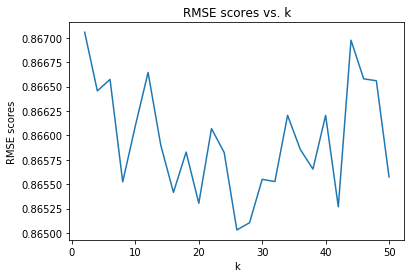

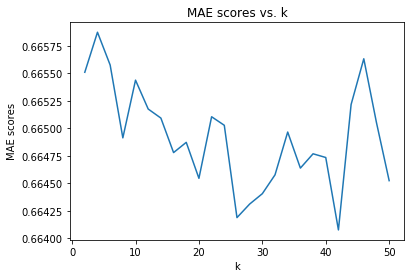

In [60]:
plt.figure()
plt.plot(ks, rmse_scores)
plt.title('RMSE scores vs. k')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

plt.figure()
plt.plot(ks, mae_scores)
plt.title('MAE scores vs. k')
plt.xlabel('k')
plt.ylabel('MAE scores')
plt.show()

#### Question 25
Find the optimal value of k.

In [61]:
best_k_MF_bias = ks[np.argmin(rmse_scores)]

print('Best k for RMSE: {}'.format(best_k_MF_bias))
print('Best k for MAE: {}'.format(ks[np.argmin(mae_scores)]))

print('Min average value for RMSE:', np.amin(rmse_scores))
print('Min average value for MAE:', np.amin(mae_scores))

Best k for RMSE: 26
Best k for MAE: 42
Min average value for RMSE: 0.8650320745151244
Min average value for MAE: 0.6640776876193643


#### Question 26
Design a MF with bias collaborative filter on popular movie trimmed test set.

In [62]:
# MF with Bias, Analyze popular dataset

rmse_popular_scores = []

for k in ks:
    svd = SVD(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        svd.fit(trainset)
        predictions = svd.test(pop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_popular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
0.8487469604121213
 
k = 4
0.8513760532016921
 
k = 6
0.8514866569952048
 
k = 8
0.8480233213813231
 
k = 10
0.8495245671412851
 
k = 12
0.8489807216612171
 
k = 14
0.8515473648111257
 
k = 16
0.8478553975598644
 
k = 18
0.8489294825741679
 
k = 20
0.8484186751578022
 
k = 22
0.8482395261749085
 
k = 24
0.8497943071828968
 
k = 26
0.8459684486924625
 
k = 28
0.8483377911324423
 
k = 30
0.848977314782519
 
k = 32
0.8489426349908541
 
k = 34
0.8471815469543674
 
k = 36
0.8480533756554017
 
k = 38
0.8502033082595737
 
k = 40
0.848960400028276
 
k = 42
0.8457769087427284
 
k = 44
0.8490085875727592
 
k = 46
0.8491714081954742
 
k = 48
0.8458828074776144
 
k = 50
0.8452120559192975
 


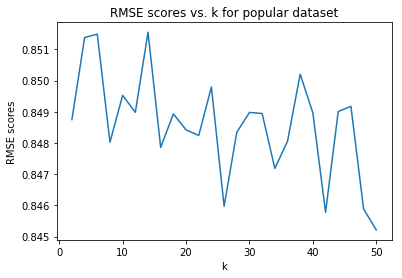

In [63]:
plt.figure()
plt.plot(ks, rmse_popular_scores)
plt.title('RMSE scores vs. k for popular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [64]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_popular_scores)]))
print('Min average value for RMSE:', np.amin(rmse_popular_scores))

Best k for RMSE: 50
Min average value for RMSE: 0.8452120559192975


#### Question 27
Design a MF with bias collaborative filter on unpopular movie trimmed test set.

In [65]:
# MF with Bias, Analyze unpopular dataset

rmse_unpopular_scores = []

for k in ks:
    svd = SVD(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        unpop_testset = get_unpopular(testset)
        svd.fit(trainset)
        predictions = svd.test(unpop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_unpopular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
0.9004344323789937
 
k = 4
0.9019851556784981
 
k = 6
0.8995168985793315
 
k = 8
0.9032977364172089
 
k = 10
0.9034192724032468
 
k = 12
0.9023005436009971
 
k = 14
0.9041187633997451
 
k = 16
0.9049139592609965
 
k = 18
0.9033595193785853
 
k = 20
0.9004802744245402
 
k = 22
0.8991509633452693
 
k = 24
0.9018518348450859
 
k = 26
0.9010403794057487
 
k = 28
0.9052199313992556
 
k = 30
0.9037205406158902
 
k = 32
0.9025097402288855
 
k = 34
0.9032253469612677
 
k = 36
0.9021512757908189
 
k = 38
0.9070316322778702
 
k = 40
0.9058117169305693
 
k = 42
0.8997654286940543
 
k = 44
0.9045349508496162
 
k = 46
0.9074571329764147
 
k = 48
0.9029311153310544
 
k = 50
0.9068387408014507
 


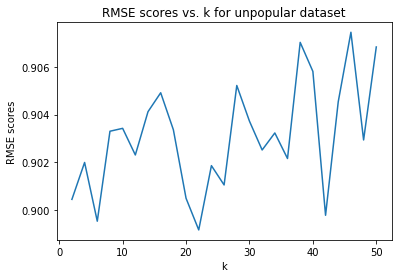

In [66]:
plt.figure()
plt.plot(ks, rmse_unpopular_scores)
plt.title('RMSE scores vs. k for unpopular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [67]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_unpopular_scores)]))
print('Min average value for RMSE:', np.amin(rmse_unpopular_scores))

Best k for RMSE: 22
Min average value for RMSE: 0.8991509633452693


#### Question 28
Design a MF with bias collaborative filter on high variance movie trimmed test set.

In [68]:
# MF with Bias, Analyze high variance dataset

rmse_highvar_scores = []

for k in ks:
    svd = SVD(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        highvar_testset = get_highvar(testset)
        svd.fit(trainset)
        predictions = svd.test(highvar_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_highvar_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.4090909741597701
 
k = 4
1.4194632961877662
 
k = 6
1.4253883229352577
 
k = 8
1.4138062484223075
 
k = 10
1.4165275296041488
 
k = 12
1.406686811129402
 
k = 14
1.3962040093415855
 
k = 16
1.4494224060198426
 
k = 18
1.3517553880939661
 
k = 20
1.3957468511976725
 
k = 22
1.4342078030114178
 
k = 24
1.3985358738763058
 
k = 26
1.4103543861313126
 
k = 28
1.3971647337641429
 
k = 30
1.3735336747570992
 
k = 32
1.4130320435624846
 
k = 34
1.3980986378008455
 
k = 36
1.3792668360481284
 
k = 38
1.3794388408559795
 
k = 40
1.4299990065766202
 
k = 42
1.4050755641826957
 
k = 44
1.44027459106155
 
k = 46
1.4165063474827533
 
k = 48
1.3549724492550073
 
k = 50
1.397714519857993
 


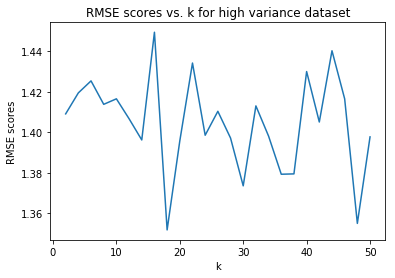

In [69]:
plt.figure()
plt.plot(ks, rmse_highvar_scores)
plt.title('RMSE scores vs. k for high variance dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [70]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_highvar_scores)]))
print('Min average value for RMSE:', np.amin(rmse_highvar_scores))

Best k for RMSE: 18
Min average value for RMSE: 1.3517553880939661


#### Question 29
Plot ROC cures from Question 24 with optimal k value. Specify AUC.

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split

In [72]:
thresholds = [2.5, 3, 3.5, 4]

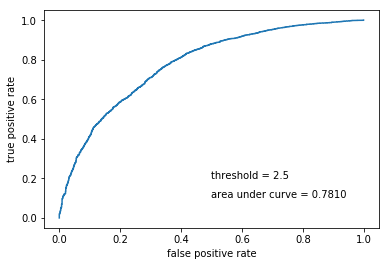

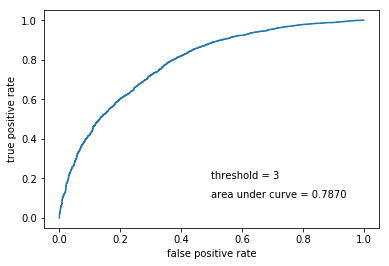

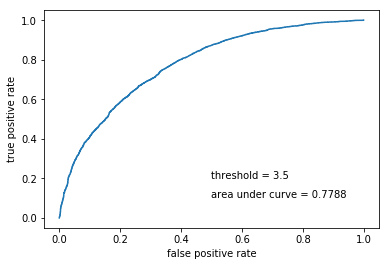

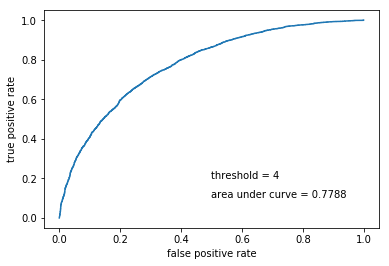

In [73]:
svd = SVD(n_factors=best_k_MF_bias)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
svd.fit(trainset)
predictions = svd.test(testset)
for t in thresholds:
    true_bin = [1 if pred.r_ui >= t else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]
    
    plt.figure()
    fpr, tpr, thr = roc_curve(true_bin, scores)
    plt.plot(fpr, tpr)
    plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(true_bin, scores))
    plt.text(0.5, 0.2, 'threshold = {}'.format(t))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

#### Question 30

Filter original R matrix into popular, unpopular, and high-variance datasets

In [8]:
print('Original', R.shape)

def get_popular_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    popular_ones = counts_per_movie > 2
    return R[:, popular_ones]
    
data_popular = get_popular_z(R)
print('Popular movies:', data_popular.shape)

def get_unpopular_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    unpopular_ones = counts_per_movie <= 2
    return R[:, unpopular_ones]
    
data_unpopular = get_unpopular_z(R)
print('Unpopular movies:', data_unpopular.shape)

def get_highvar_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    count_popular = counts_per_movie >= 5
    
    # manually calculate variances:
    variances_per_movie = np.zeros(R.shape[1])
    for idx, col in enumerate(R.T):
        nonzero = np.nonzero(col)
        variances_per_movie[idx] = np.var(col[nonzero])
    
    high_var = variances_per_movie >= 2
    
    return R[:, np.all([count_popular, high_var], axis=0)]

data_highvar = get_highvar_z(R)
print('High-var movies:', data_highvar.shape)

Original (610, 9724)
Popular movies: (610, 4980)
Unpopular movies: (610, 4744)
High-var movies: (610, 40)


##### Define Naive model

Calculate the average rating, $\mu_i$, for each user rating, $r_i$

In [9]:
class Naive():
    '''
    Custom collaborative filter designed to work with the cross-validation function
    '''

    # mean ratings, one required per user
    mu_i = None

    def __init__(self, X_train):
        self.mu_i = np.zeros(np.mean(X_train, axis=1).shape)
        self.fit(X_train, None, enabled=True)

    # calculate mu_i for training
    def fit(self, X, y, enabled=False):
        if enabled:
            for idx, row in enumerate(X):
                self.mu_i[idx] = np.mean(row[np.nonzero(row)])

    # return mu_i as rating prediction (for each movie)
    def predict(self, X, inds=None):
        if inds is None:
            return np.repeat(np.reshape(self.mu_i, (self.mu_i.shape[0], 1)), X.shape[1], axis=1)
        else:
            # return a specific set of mu_i's:
            return np.repeat(np.reshape(self.mu_i[inds], (self.mu_i[inds].shape[0], 1)), X.shape[1], axis=1)

Custom cross validation function

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


def custom_crossval(X_train, y_train, model, num_folds=10, metrics=['RMSE', 'MAE', 'accuracy'],
                    randomize=True, include_inds=False):
    '''
    Requires a model that has the following functions:
        model.fit(X, y): fits the model on a particular set of X/y
        model.predict(X): predicts y given an input of X
    '''
    X_train_folds = []
    y_train_folds = []
    X_val_folds = []
    y_val_folds = []

    # necessary for some models (Naive)
    train_inds = []
    val_inds = []

    # initialize cumulative errors object
    cumulative_metrics = {}
    for met in metrics:
        cumulative_metrics[met] = 0

    k = num_folds

    ##############################################################################
    # 1. Divide dataset into training and validation folds
    idx = np.arange(X_train.shape[0])
    fold_size = X_train.shape[0] // num_folds

    # randomize indices
    if randomize:
        np.random.shuffle(idx)

    for i in range(num_folds):
        test_idx = idx[i * fold_size:(i + 1) * fold_size]
        train_idx = np.concatenate((idx[:i * fold_size:], idx[(i + 1) * fold_size:]))

        X_train_folds.append(X_train[train_idx])
        y_train_folds.append(y_train[train_idx])

        X_val_folds.append(X_train[test_idx])
        y_val_folds.append(y_train[test_idx])

        train_inds.append(train_idx)
        val_inds.append(test_idx)
        
    # initialize metric lists
    for met in metrics:
        cumulative_metrics[met] = []

    ##############################################################################
    # 2. Train on train set, test on validation set, calculate errors
    for i in range(len(X_train_folds)):
        # train model on the train folds (k-1 folds):
        model.fit(X_train_folds[i], y_train_folds[i])

        # measure error of test predictions
        if include_inds:
            y_pred = model.predict(X_val_folds[i], inds=val_inds[i])
        else:
            y_pred = model.predict(X_val_folds[i])

        # calculate errors:
        y_actual = y_val_folds[i]
        
        nonzero = np.nonzero(y_actual)
        for met in metrics:
            if met == 'RMSE':
                rms = sqrt(mean_squared_error(y_actual[nonzero], y_pred[nonzero]))
                cumulative_metrics[met].append(rms)
            elif met == 'MAE':
                mae = mean_absolute_error(y_actual[nonzero], y_pred[nonzero])
                cumulative_metrics[met].append(mae)
            elif met == 'accuracy':
                num_correct = np.sum(y_pred[nonzero] == y_actual[nonzero])
                cumulative_metrics[met].append(num_correct / y_val_folds[i].shape[0])
            else:
                raise Exception("Error: requested error ('{}') is not incoporated into this function yet.".format(met))

    ##############################################################################
    # 3. Average and return metrics object
    for met in metrics:
        cumulative_metrics["{}_avg".format(met)] = np.mean(cumulative_metrics[met])
    return cumulative_metrics

In [11]:
model = Naive(R)
mu_i = model.mu_i
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

y_pred = model.predict(R)
print(R.shape, y_pred.shape)

average rating shape: (610,) - should be 610
average rating range: 1.275 5.0
(610, 9724) (610, 9724)


In [12]:
error = custom_crossval(R, R, model, num_folds=10, metrics=['RMSE', 'MAE'],
                        randomize=False, include_inds=True)

print('RMSE:', error['RMSE'])
print('Average:', error['RMSE_avg'])

RMSE: [0.980377644026666, 0.8894267281038554, 0.9578416198079053, 0.9027217645774974, 0.9255560254043154, 0.9117285135298724, 0.9465737923430447, 0.9410266745252384, 0.9939839815672974, 0.9242411001224387]
Average: 0.937347784400813


#### Question 31

In [13]:
# model = Naive(data_popular)
error = custom_crossval(data_popular, data_popular, model, num_folds=10, metrics=['RMSE', 'MAE'],
                        randomize=False, include_inds=True)

print('RMSE popular-trimmed data:', error['RMSE'])
print('Average:', error['RMSE_avg'])

RMSE popular-trimmed data: [0.9772433030189075, 0.8803782938378956, 0.9585488778167809, 0.8956604800433992, 0.9231132955809138, 0.9118603953011065, 0.9428048598381606, 0.9437903395000913, 0.9894158068194451, 0.9228684288270669]
Average: 0.9345684080583767


#### Question 32

In [16]:
# model = Naive(data_unpopular)
error = custom_crossval(data_unpopular, data_unpopular, model, num_folds=10, metrics=['RMSE', 'MAE'],
                        randomize=False, include_inds=True)

print('RMSE unpopular-trimmed data:', error['RMSE'])
print('Average:', error['RMSE_avg'])

RMSE unpopular-trimmed data: [1.0561917419099505, 0.9981303401161437, 0.937437813725344, 1.0831281659706797, 0.9943208413745765, 0.909345213649323, 1.0007562505280165, 0.9128780746587065, 1.092262113773724, 0.9373612536593925]
Average: 0.9921811809365858


#### Question 33

In [15]:
# model = Naive(data_highvar)
error = custom_crossval(data_highvar, data_highvar, model, num_folds=10, metrics=['RMSE', 'MAE'],
                        randomize=False, include_inds=True)

print('RMSE high-variance-trimmed data:', error['RMSE'])
print('Average:', error['RMSE_avg'])

RMSE high-variance-trimmed data: [1.832221602396677, 1.368264785638802, 1.6320849074985369, 1.7816921791526146, 1.4424431104412154, 1.317276683254397, 1.1891331442068152, 1.6118238341199815, 1.551091924881938, 1.3973496709893045]
Average: 1.5123381842580284


#### Question 34

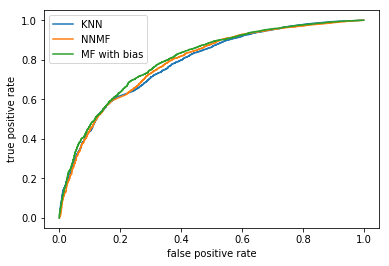

In [98]:
# KNN
knn = KNNWithMeans(k=21, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
knn.fit(trainset)
predictions_knn = knn.test(testset)

# NNMF
nmf = NMF(n_factors=16)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
nmf.fit(trainset)
predictions_nmf = nmf.test(testset)

# MF with Bias
svd = SVD(n_factors=best_k_MF_bias)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
svd.fit(trainset)
predictions_mf = svd.test(testset)

threshold = 3

# predictions array
predicts = [predictions_knn, predictions_nmf, predictions_mf]

#labels for legend
labels = ['KNN', 'NNMF', 'MF with bias']

plt.figure()

for p in predicts:
    true_bin = [1 if pred.r_ui >= threshold else 0 for pred in p]
    scores = [pred.est for pred in p]
    
    
    fpr, tpr, thr = roc_curve(true_bin, scores)
    plt.plot(fpr, tpr)
#     plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(true_bin, scores))
#     plt.text(0.5, 0.2, 'threshold = {}'.format(t))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(labels)
    

In [ ]:
# Function for Question 36, 37, 38 and 39
# ref: https://tinyurl.com/yylquwb8

def ranking_predictions(predictions, t):
    
    # we need to use the threshold 3 for obtaining G set.
    threshold = 3
    
    precisions = {}
    recalls = {}
    
    ground_truth_user = defaultdict(list)
    
    #predictions for each user
    for uid, _, true_r, est, _ in predictions:
        ground_truth_user[uid].append((est, true_r))

    
    for uid, user_ratings in ground_truth_user.items():
        # we simply skip over the users who have rated less than t items
        if len(user_ratings) < t:
            continue
    
        # sorting the dict in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        relevant_items = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        
        
        # we simply skip over the users who have |G| = 0
        if relevant_items is 0:
            continue
        
        # Number of recommended items in first k ratings
        recommended_items = sum((est >= threshold) for (est, _) in user_ratings[:t])

        # Number of relevant and recommended items in first k ratings
        relevant_recommended_items = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:t])

        # Precision is the proportion of relevant and recommended items by recommended items
        if recommended_items != 0:
            precisions[uid] = relevant_recommended_items / recommended_items

        # Recall is the proportion of relevant and recommended items by relevant items
        if relevant_items != 0:
            recalls[uid] = relevant_recommended_items / relevant_items
            
    recall_values = list(recalls.values())
    precision_values = list(precisions.values())
    
    # return the average values
    return np.mean(precision_values), np.mean(recall_values)

## Question 36

In [45]:
t_list = np.arange(1, 26, 1) # list to store size of items

In [46]:
# KNN

avg_precisions_knn = []
avg_recalls_knn = []

num_folds = 10

start_time = time.time()

print("Execution Started")
for t in t_list:
    total_precisions = 0
    total_recalls = 0
    
    knn = KNNWithMeans(k=22, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    kf = KFold(n_splits=num_folds)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        knn.fit(trainset)
        predictions = knn.test(pop_testset)
        precisions_avg, recalls_avg = ranking_predictions(predictions, t)
        total_precisions = total_precisions + precisions_avg
        total_recalls = total_recalls + recalls_avg
   
    avg_precisions_knn.append(total_precisions/num_folds)
    avg_recalls_knn.append(total_recalls/num_folds)

print("Program executed succefully")
print("Total time elapsed: {}".format(time.time() - start_time))

Execution Started
Program executed succefully
Total time elapsed: 289.60084199905396


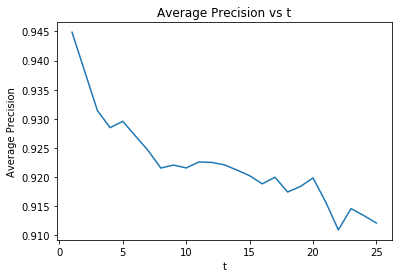

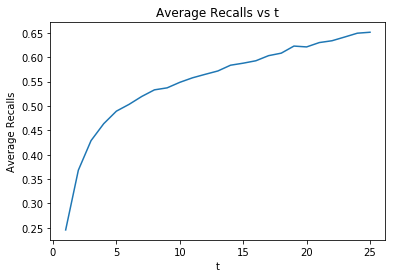

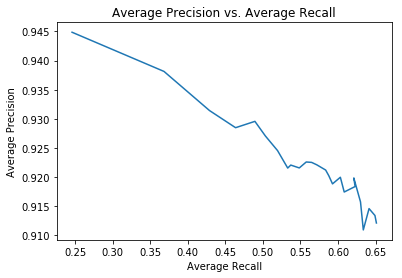

In [47]:
plt.figure()
plt.plot(t_list, avg_precisions_knn)
plt.title("Average Precision vs t")
plt.ylabel("Average Precision")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(t_list, avg_recalls_knn)
plt.title("Average Recalls vs t")
plt.ylabel("Average Recalls")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(avg_recalls_knn, avg_precisions_knn)
plt.title("Average Precision vs. Average Recall")
plt.ylabel("Average Precision")
plt.xlabel("Average Recall")
plt.show()

## Question 37

In [38]:
# NNMF

avg_precisions_nnmf = []
avg_recalls_nnmf = []

num_folds = 10

start_time = time.time()

print("Execution Started")
for t in t_list:
    total_precisions = 0
    total_recalls = 0
    
    nmf = NMF(n_factors=18)
    kf = KFold(n_splits=num_folds)
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        nmf.fit(trainset)
        predictions = nmf.test(pop_testset)
        precisions_avg, recalls_avg = ranking_predictions(predictions, k=t)
        total_precisions = total_precisions + precisions_avg
        total_recalls = total_recalls + recalls_avg
   
    avg_precisions_nnmf.append(total_precisions/num_folds)
    avg_recalls_nnmf.append(total_recalls/num_folds)

print("Program executed succefully")
print("Total time elapsed: {}".format(time.time() - start_time))

Execution Started
Program executed succefully
Total time elapsed: 1626.113520860672


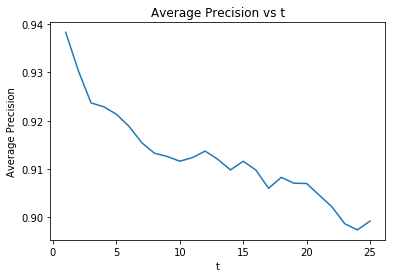

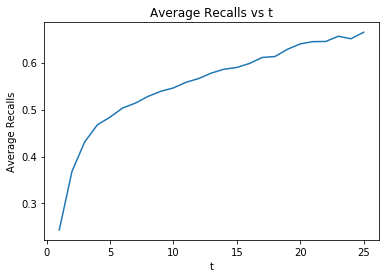

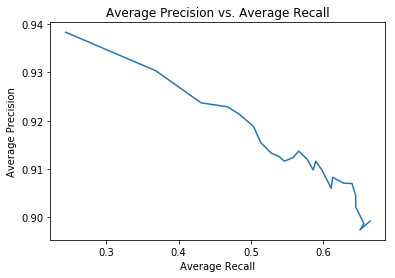

In [39]:
plt.figure()
plt.plot(t_list, avg_precisions_nnmf)
plt.title("Average Precision vs t")
plt.ylabel("Average Precision")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(t_list, avg_recalls_nnmf)
plt.title("Average Recalls vs t")
plt.ylabel("Average Recalls")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(avg_recalls_nnmf, avg_precisions_nnmf)
plt.title("Average Precision vs. Average Recall")
plt.ylabel("Average Precision")
plt.xlabel("Average Recall")
plt.show()

## Question 38

In [32]:
# MF with bias

avg_precisions_mf = []
avg_recalls_mf = []

num_folds = 10

start_time = time.time()

print("Execution Started")
for t in t_list:
    total_precisions = 0
    total_recalls = 0
    
    svd = SVD(n_factors=24)
    kf = KFold(n_splits=num_folds)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        svd.fit(trainset)
        predictions = svd.test(pop_testset)
        precisions_avg, recalls_avg = ranking_predictions(predictions, t)
        total_precisions = total_precisions + precisions_avg
        total_recalls = total_recalls + recalls_avg
   
    avg_precisions_mf.append(total_precisions/num_folds)
    avg_recalls_mf.append(total_recalls/num_folds)

print("Program executed succefully")
print("Total time elapsed: {}".format(time.time() - start_time))

Execution Started
Program executed succefully
Total time elapsed: 714.4937727451324


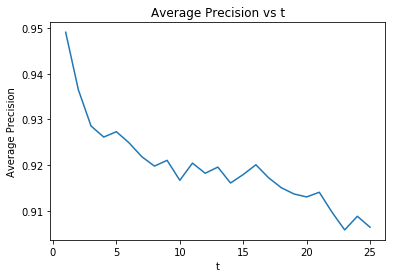

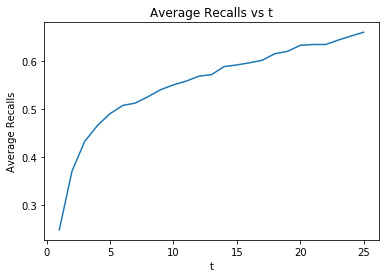

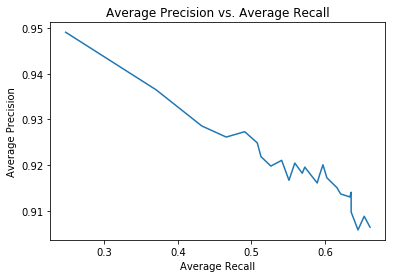

In [33]:
plt.figure()
plt.plot(t_list, avg_precisions_mf)
plt.title("Average Precision vs t")
plt.ylabel("Average Precision")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(t_list, avg_recalls_mf)
plt.title("Average Recalls vs t")
plt.ylabel("Average Recalls")
plt.xlabel("t")
plt.show()

plt.figure()
plt.plot(avg_recalls_mf, avg_precisions_mf)
plt.title("Average Precision vs. Average Recall")
plt.ylabel("Average Precision")
plt.xlabel("Average Recall")
plt.show()

## Question 39

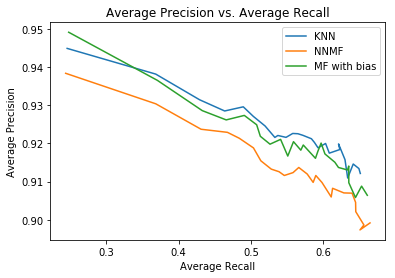

In [48]:
labels = ['KNN', 'NNMF', 'MF with bias']

plt.figure()

# KNN
plt.plot(avg_recalls_knn, avg_precisions_knn)

#NNMF
plt.plot(avg_recalls_nnmf, avg_precisions_nnmf)

#MF with bias
plt.plot(avg_recalls_mf, avg_precisions_mf)

plt.xlabel('Average Recall')
plt.ylabel('Average Precision')
plt.title('Average Precision vs. Average Recall')
plt.legend(labels)

plt.show()